In [1]:
from mipy.data import saved_data, saved_acquisition_schemes
import matplotlib.pyplot as plt
%matplotlib inline
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


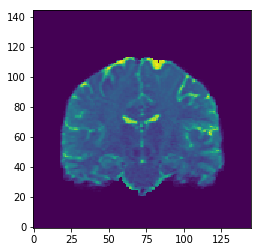

In [2]:
plt.imshow(data_hcp[:,0,:,0].T, origin=True)

In [3]:
sub_image = data_hcp[70:90,:, 70:90]

In [4]:
from mipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G4Zeppelin()

In [5]:
from mipy.utils.utils import parameter_equality, T1_tortuosity
watson_bundle_links = [
    (zeppelin, 'lambda_perp', T1_tortuosity, [(stick, 'lambda_par'), (None, 'partial_volume_0')]),
    (zeppelin, 'lambda_par',  parameter_equality,   [(stick, 'lambda_par')])
]

In [6]:
from mipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle1 = SD1WatsonDistributed(models=[stick, zeppelin],
                                               parameter_links=watson_bundle_links)
watson_dispersed_bundle2 = SD1WatsonDistributed(models=[stick, zeppelin],
                                               parameter_links=watson_bundle_links)

In [7]:
from mipy.core.modeling_framework import MultiCompartmentModel
NODDIx_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle1, watson_dispersed_bundle2])
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle1])

In [8]:
NODDIx_mod.parameter_cardinality

OrderedDict([('SD1WatsonDistributed_2_C1Stick_1_lambda_par', 1),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_2_SD1Watson_1_odi', 1),
             ('SD1WatsonDistributed_2_partial_volume_0', 1),
             ('G3Ball_1_lambda_iso', 1),
             ('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1),
             ('SD1WatsonDistributed_2_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

In [9]:
NODDIx_mod.fix_parameter('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1.7e-9)
NODDIx_mod.fix_parameter('SD1WatsonDistributed_2_C1Stick_1_lambda_par', 1.7e-9)
NODDIx_mod.fix_parameter('G3Ball_1_lambda_iso', 3e-9)

In [10]:
NODDIx_mod.parameter_cardinality

OrderedDict([('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_2_SD1Watson_1_odi', 1),
             ('SD1WatsonDistributed_2_partial_volume_0', 1),
             ('SD1WatsonDistributed_2_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

In [11]:
NODDI_mod.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [12]:
NODDI_mod.fix_parameter('G3Ball_1_lambda_iso', 3e-9)
NODDI_mod.fix_parameter('SD1WatsonDistributed_1_C1Stick_1_lambda_par', 1.7e-9)

In [26]:
NODDIx_fit = NODDIx_mod.fit(scheme_hcp, sub_image, solver='mix')

Using parallel processing with 8 workers.
Setup MIX optimizer in 1.00135803223e-05 seconds
Fitting of 400 voxels complete in 6445.14053893 seconds.
Average of 16.1128513473 seconds per voxel.


In [ ]:
fitted_parameters = NODDIx_fit.fitted_parameters

fig, axs = plt.subplots(3, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

## FODs

In [ ]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = NODDIx_fit.fod(sphere.vertices)

In [ ]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

volume_res = fitted_parameters['partial_volume_0']
volume_im = slicer(volume_res[:, 0], interpolation='nearest', affine=affine, opacity=0.7)

In [ ]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, volume_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

## Parameter Cascading using CSD

In [13]:
from dipy.reconst.csdeconv import auto_response
from mipy.core.acquisition_scheme import gtab_mipy2dipy
gtab = gtab_mipy2dipy(scheme_hcp)
response, ratio = auto_response(gtab, data_hcp, roi_radius=20, fa_thr=0.7)

In [14]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [15]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

In [16]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(model=csd_model,
                             data=sub_image,
                             sphere=sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

In [17]:
from dipy.viz import fvtk
ren = fvtk.ren()
fodf_peaks = fvtk.peaks(csd_peaks.peak_dirs, csd_peaks.peak_values, scale=1.3)
fvtk.add(ren, fodf_peaks)
fvtk.show(ren)

Use peaks and number of peaks 

In [18]:
import numpy as np
Npeaks = np.sum(csd_peaks.peak_values>0, axis=-1)
mask1peak = Npeaks == 1
mask2peak = Npeaks > 1

In [19]:
from mipy.utils.utils import cart2mu

In [20]:
mu_1 = cart2mu(csd_peaks.peak_dirs[..., 0, :])
mu_2 = cart2mu(csd_peaks.peak_dirs[..., 1, :])

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/mipy/utils/utils.py:349: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


In [21]:
NODDI_mod.parameter_cardinality

OrderedDict([('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [22]:
x0_NODDI = NODDI_mod.parameter_initial_guess_to_parameter_vector(SD1WatsonDistributed_1_SD1Watson_1_mu=mu_1)

SD1WatsonDistributed_1_SD1Watson_1_mu successfully set.


In [23]:
x0_NODDIx = NODDIx_mod.parameter_initial_guess_to_parameter_vector(SD1WatsonDistributed_1_SD1Watson_1_mu=mu_1,
                                                                   SD1WatsonDistributed_2_SD1Watson_1_mu=mu_2)

SD1WatsonDistributed_1_SD1Watson_1_mu successfully set.
SD1WatsonDistributed_2_SD1Watson_1_mu successfully set.


In [24]:
NODDIx_fit_with_x0 = NODDIx_mod.fit(scheme_hcp, sub_image, parameter_initial_guess=x0_NODDIx, mask=mask2peak)

Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000375032424927 seconds
Fitting of 213 voxels complete in 4124.99298406 seconds.
Average of 19.3661642444 seconds per voxel.


In [25]:
NODDI_fit_with_x0 = NODDI_mod.fit(scheme_hcp, sub_image, parameter_initial_guess=x0_NODDI, mask=mask1peak)

Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000308036804199 seconds
Fitting of 187 voxels complete in 31.8601949215 seconds.
Average of 0.170375373912 seconds per voxel.


In [39]:
fods = np.zeros(np.r_[sub_image.shape[:-1], len(sphere.vertices)])
fods[mask1peak] = NODDI_fit_with_x0.fod(sphere.vertices)[mask1peak]
fods[mask2peak] = NODDIx_fit_with_x0.fod(sphere.vertices)[mask2peak]

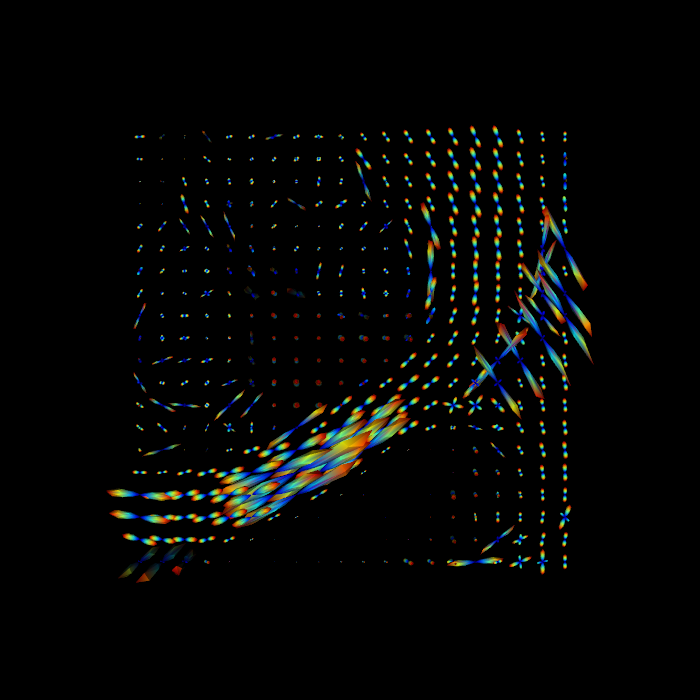

In [40]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
# fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

Looks OK... But nothing special

In [41]:
fods_mix = NODDIx_fit.fod(sphere.vertices)

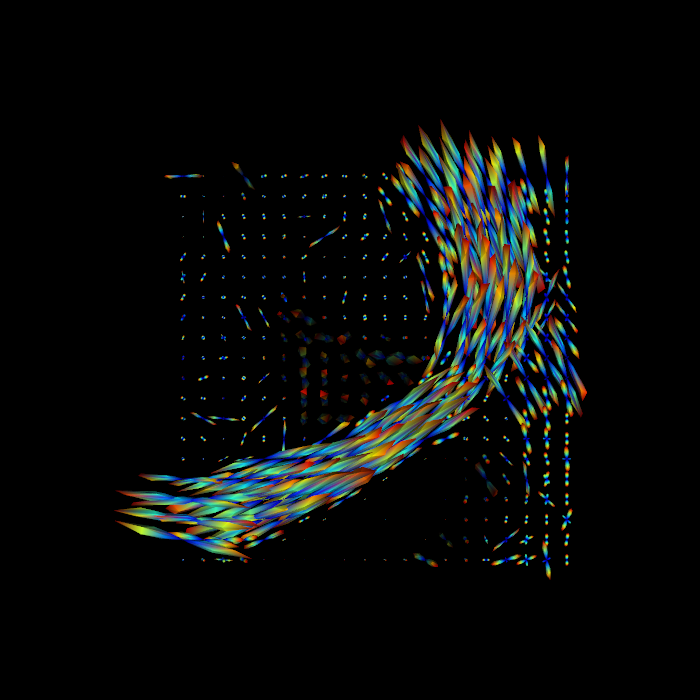

In [42]:
fods_mix = NODDIx_fit.fod(sphere.vertices)

from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
# fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

Experiment looks to be success. I'm just going to manually truncate the ODI now to see if the angles look ok.

In [65]:
NODDIx_fit.fitted_parameters_vector[..., 3] = np.clip(NODDIx_fit.fitted_parameters_vector[..., 3], 0.03, 1.)
NODDIx_fit.fitted_parameters_vector[..., 7] = np.clip(NODDIx_fit.fitted_parameters_vector[..., 7], 0.03, 1.)

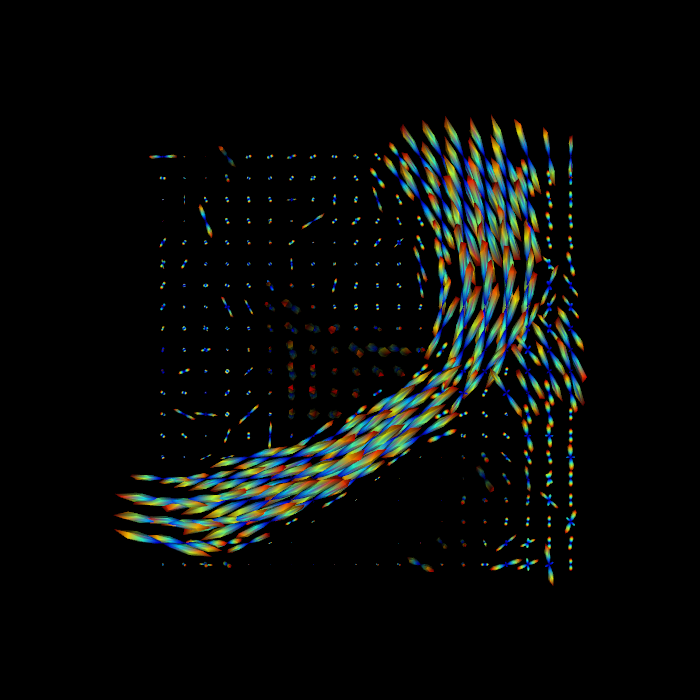

In [66]:
fods_mix = NODDIx_fit.fod(sphere.vertices)

from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
# fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

In [67]:
NODDIx_fit.fitted_parameters_vector[..., 3] = np.clip(NODDIx_fit.fitted_parameters_vector[..., 3], 0.04, 1.)
NODDIx_fit.fitted_parameters_vector[..., 7] = np.clip(NODDIx_fit.fitted_parameters_vector[..., 7], 0.04, 1.)

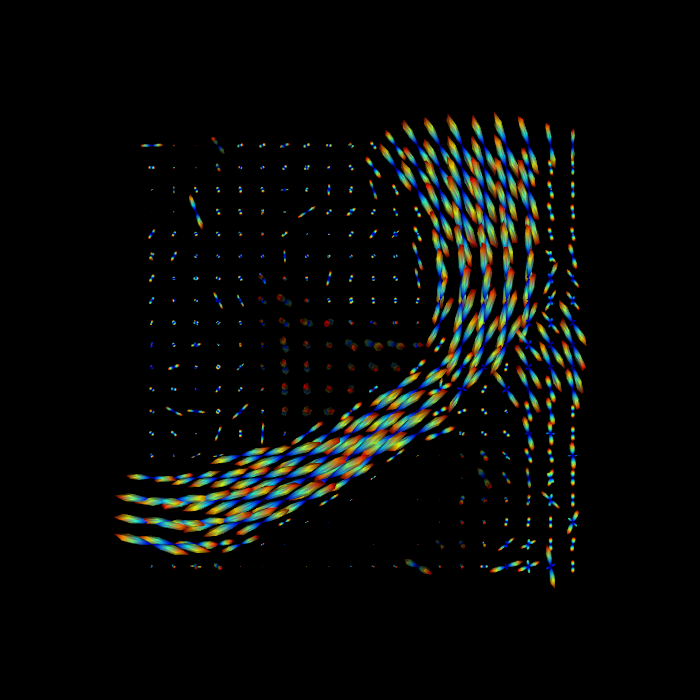

In [68]:
fods_mix = NODDIx_fit.fod(sphere.vertices)

from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
# fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

In [69]:
NODDIx_fit.fitted_parameters_vector[..., 3] = np.clip(NODDIx_fit.fitted_parameters_vector[..., 3], 0.05, 1.)
NODDIx_fit.fitted_parameters_vector[..., 7] = np.clip(NODDIx_fit.fitted_parameters_vector[..., 7], 0.05, 1.)

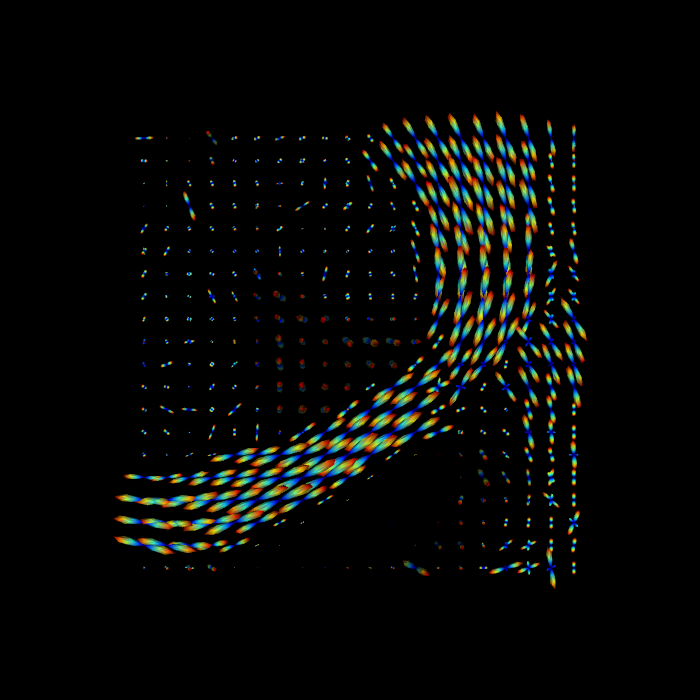

In [70]:
fods_mix = NODDIx_fit.fod(sphere.vertices)

from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
# fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

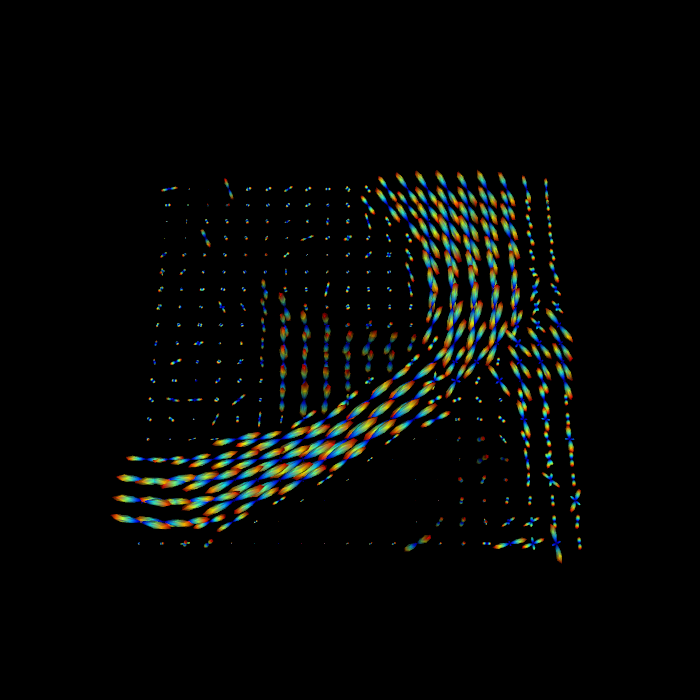

In [76]:
fods_mix = NODDIx_fit.fod(sphere.vertices)

from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(60)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
# fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

Looks perfect!